In [1]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D, GRU, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

In [2]:
df_train = pd.read_csv('../Dataset/emotion/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('../Dataset/emotion/test.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_val = pd.read_csv('../Dataset/emotion/val.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')

In [3]:
df_train

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [4]:
df_test

,Input,Sentiment
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


In [5]:
df_val

,Input,Sentiment
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [6]:
encoding = { 'anger': 0,
    'fear': 1,
    'joy': 2,
    'love': 3,
    'sadness': 4,
    'surprise': 5
}

df_train['Sentiment'] = [encoding[key] for key in df_train['Sentiment'].values]
df_val['Sentiment'] = [encoding[key] for key in df_val['Sentiment'].values]
df_test['Sentiment'] = [encoding[key] for key in df_test['Sentiment'].values]

In [7]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encode = LabelEncoder()

labels_train = encode.fit_transform(df_train['Sentiment'])
labels_test = encode.fit_transform(df_test['Sentiment'])
labels_val = encode.fit_transform(df_val['Sentiment'])

y_train = np_utils.to_categorical(labels_train)
y_test = np_utils.to_categorical(labels_test)
y_val = np_utils.to_categorical(labels_val)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(16000, 6)
(2000, 6)
(2000, 6)


In [8]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [9]:
EMBEDDING_FILE = 'wiki-news-300d-1M.vec'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=False)

In [10]:
import nltk
# Uncomment to download "stopwords"
#nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [11]:
import re

# Preprocess text
X_train_preprocessed = [text_preprocessing(text) for text in df_train['Input'].values]
X_val_preprocessed = [text_preprocessing(text) for text in df_val['Input'].values]
X_test_preprocessed = [text_preprocessing(text) for text in df_test['Input'].values]

In [12]:
X_train_preprocessed

['didnt feel humiliated',
 'can go feeling hopeless damned hopeful around someone cares awake',
 'im grabbing minute post feel greedy wrong',
 'ever feeling nostalgic fireplace know still property',
 'feeling grouchy',
 'ive feeling little burdened lately wasnt sure',
 'ive taking milligrams times recommended amount ive fallen asleep lot faster also feel like funny',
 'feel confused life teenager jaded year old man',
 'petronas years feel petronas performed well made huge profit',
 'feel romantic',
 'feel like make suffering seeing mean something',
 'feel running divine experience can expect type spiritual encounter',
 'think easiest time year feel dissatisfied',
 'feel low energy thirsty',
 'immense sympathy general point possible proto writer trying find time write corners life sign agent let alone publishing contract feels little precious',
 'not feel reassured anxiety side',
 'didnt really feel embarrassed',
 'feel pretty pathetic time',
 'started feeling sentimental dolls child be

In [13]:
MAX_NB_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train_preprocessed + X_val_preprocessed)

sequences_train = tokenizer.texts_to_sequences(X_train_preprocessed)
sequences_val = tokenizer.texts_to_sequences(X_val_preprocessed)
sequences_test = tokenizer.texts_to_sequences(X_test_preprocessed)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 16049 unique tokens


In [14]:
MAX_SEQUENCE_LENGTH = 140
data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
data_val = pad_sequences(sequences_val, maxlen=MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data_train.shape)

Shape of data tensor: (16000, 140)


In [15]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# define oversampling strategy
SMOTE = SMOTE(random_state=42)

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(data_train, y_train)
X_val_SMOTE, y_val_SMOTE = SMOTE.fit_resample(data_val, y_val)

# summarize class distribution
#print("After oversampling: ", Counter(y_train_SMOTE))

In [16]:
print(len(X_train_SMOTE))
print(len(y_train_SMOTE))
print(len(X_val_SMOTE))
print(len(y_val_SMOTE))

32172
32172
4224
4224


In [35]:
EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

In [36]:
for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < len(word_index):
        embedding_matrix[idx] = word2vec.word_vec(word)

In [37]:
print(embedding_matrix)
print(embedding_matrix.shape)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0372      0.0615      0.0167     ...  0.14049999 -0.0883
  -0.1164    ]
 [ 0.0174      0.0295     -0.1055     ...  0.17470001 -0.0292
  -0.1131    ]
 ...
 [ 0.0676     -0.0488      0.0277     ...  0.0195      0.207
   0.119     ]
 [-0.199      -0.0104      0.0448     ...  0.3477      0.0527
  -0.0252    ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(16050, 300)


In [38]:
print(X_train_SMOTE)
print(X_val_SMOTE)
print(data_test)
print(y_train_SMOTE)
print(y_val_SMOTE)
print(y_test)

[[   0    0    0 ...   52    1  544]
 [   0    0    0 ...   56 1463 1177]
 [   0    0    0 ...    1  409  345]
 ...
 [   0    0    0 ... 6351 3208 3619]
 [   0    0    0 ...  154  145  812]
 [   0    0    0 ...  292  569  704]]
[[    0     0     0 ...   106  5275   432]
 [    0     0     0 ...   486  1334   994]
 [    0     0     0 ...     3   495 15102]
 ...
 [    0     0     0 ...  1140  1717  5316]
 [    0     0     0 ...    35     1   329]
 [    0     0     0 ...   125    26  1691]]
[[   0    0    0 ...    5 5795   39]
 [   0    0    0 ...  137    1  350]
 [   0    0    0 ...    1    3  291]
 ...
 [   0    0    0 ...  192    2 3619]
 [   0    0    0 ...  114  853 2584]
 [   0    0    0 ...  191  191 2021]]
[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 ...
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]
[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 ...
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]

In [43]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [44]:
import tensorflow as tf
print(len(tf.config.experimental.list_physical_devices('GPU')))

2


In [45]:
with tf.device('/device:GPU:1'):
    model = Sequential()
    # Embedded layer
    model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))

    # Convolutional Layer
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # LSTM Layer
    model.add(LSTM(300))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(6, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 300)          4815000   
_________________________________________________________________
conv1d (Conv1D)              (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               399600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               3

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model.fit(X_train_SMOTE, y_train_SMOTE, validation_data=(X_val_SMOTE, y_val_SMOTE), epochs=10, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1006/1006 [==============================] - 11s 11ms/step - loss: 1.4488 - acc: 0.4090 - val_loss: 1.2987 - val_acc: 0.4901
Epoch 2/10
1006/1006 [==============================] - 10s 10ms/step - loss: 1.1866 - acc: 0.5332 - val_loss: 1.1786 - val_acc: 0.5308
Epoch 3/10
1006/1006 [==============================] - 10s 10ms/step - loss: 1.0916 - acc: 0.5673 - val_loss: 1.1378 - val_acc: 0.5457
Epoch 4/10
1006/1006 [==============================] - 10s 10ms/step - loss: 1.0435 - acc: 0.5822 - val_loss: 1.1447 - val_acc: 0.5393
Epoch 5/10
1006/1006 [==============================] - 10s 10ms/step - loss: 1.0217 - acc: 0.5876 - val_loss: 1.1233 - val_acc: 0.5481
Epoch 6/10
1006/1006 [==============================] - 10s 10ms/step - loss: 0.9807 - acc: 0.6023 - val_loss: 1.0965 - val_acc: 0.5594
Epoch 7/10
1006/1006 [==============================] - 10s 10ms/step - loss: 0.9588 - acc: 0.6086 - val_loss: 1.0946 - val_acc: 0.5535
Epoch 8/10
1006/1006 [==========================

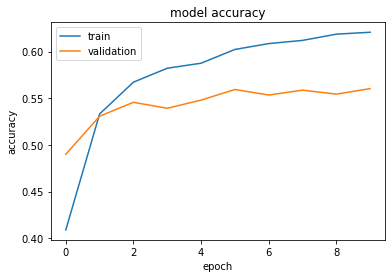

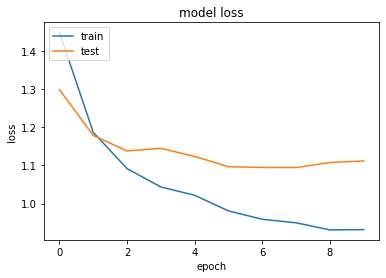

In [47]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model.predict(data_test)
    labels_pred = np.round(labels_pred)
    accuracy = accuracy_score(y_test, labels_pred)
    f1 = f1_score(y_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(y_test, labels_pred))

Accuracy: 86.75%
F1 Score: 90.03
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       275
           1       0.95      0.81      0.88       224
           2       0.96      0.89      0.92       695
           3       0.81      0.81      0.81       159
           4       0.96      0.93      0.94       581
           5       0.74      0.68      0.71        66

   micro avg       0.94      0.87      0.90      2000
   macro avg       0.89      0.82      0.85      2000
weighted avg       0.94      0.87      0.90      2000
 samples avg       0.87      0.87      0.87      2000



In [49]:
model.save('model/word2vec_CNN_LSTM-Emotion.h5')

In [50]:
with tf.device('/device:GPU:1'):
    model2 = Sequential()
    # Embedded layer
    model2.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))

    # Convolutional Layer
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Dropout(0.2))

    # LSTM Layer
    model2.add(LSTM(300))
    model2.add(Dropout(0.2))
    model2.add(Dense(100, activation='relu'))
    model2.add(Dense(6, activation='softmax'))

    model2.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          4815000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 606       
Total params: 5,566,906
Trainable params: 751,906
Non-trainable params: 4,815,000
_________________________________________________________________
None


In [51]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model2.fit(X_train_SMOTE, y_train_SMOTE, validation_data=(X_val_SMOTE, y_val_SMOTE), epochs=10, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1006/1006 [==============================] - 13s 13ms/step - loss: 1.3617 - acc: 0.4564 - val_loss: 1.2486 - val_acc: 0.5062
Epoch 2/10
1006/1006 [==============================] - 13s 13ms/step - loss: 1.0785 - acc: 0.5726 - val_loss: 1.1118 - val_acc: 0.5585
Epoch 3/10
1006/1006 [==============================] - 13s 13ms/step - loss: 0.9973 - acc: 0.5999 - val_loss: 1.0832 - val_acc: 0.5606
Epoch 4/10
1006/1006 [==============================] - 13s 13ms/step - loss: 0.9479 - acc: 0.6126 - val_loss: 1.0749 - val_acc: 0.5689
Epoch 5/10
1006/1006 [==============================] - 13s 13ms/step - loss: 0.9024 - acc: 0.6282 - val_loss: 1.0844 - val_acc: 0.5651
Epoch 6/10
1006/1006 [==============================] - 13s 13ms/step - loss: 0.8609 - acc: 0.6448 - val_loss: 1.0753 - val_acc: 0.5705
Epoch 7/10
1006/1006 [==============================] - 13s 13ms/step - loss: 0.9534 - acc: 0.6128 - val_loss: 1.0868 - val_acc: 0.5653


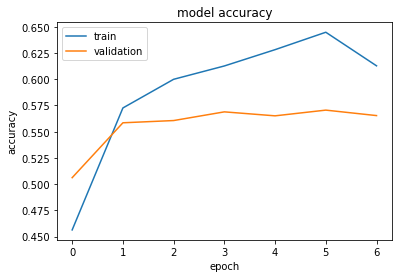

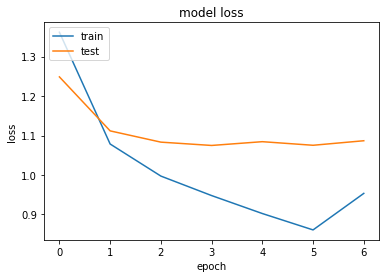

In [52]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model2.predict(data_test)
    labels_pred = np.round(labels_pred)
    accuracy = accuracy_score(y_test, labels_pred)
    f1 = f1_score(y_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(y_test, labels_pred))

Accuracy: 86.15%
F1 Score: 89.99
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       275
           1       0.97      0.82      0.89       224
           2       0.96      0.88      0.92       695
           3       0.83      0.78      0.80       159
           4       0.97      0.89      0.93       581
           5       0.70      0.80      0.75        66

   micro avg       0.94      0.86      0.90      2000
   macro avg       0.90      0.84      0.86      2000
weighted avg       0.94      0.86      0.90      2000
 samples avg       0.86      0.86      0.86      2000



In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), labels_pred.argmax(axis=1))

array([[263,   2,   0,   0,  10,   0],
       [ 17, 184,   0,   0,   4,  19],
       [ 53,   0, 612,  26,   2,   2],
       [ 12,   0,  23, 124,   0,   0],
       [ 58,   3,   1,   0, 517,   2],
       [  8,   1,   3,   0,   1,  53]])

In [55]:
model2.save('model/word2vec_LSTM-Emotion.h5')

In [56]:
with tf.device('/device:GPU:1'):
    model3 = Sequential()
    # Embedded layer
    model3.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))

    # Convolutional Layer
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Dropout(0.2))

    # LSTM Layer
    model3.add(Bidirectional(LSTM(300)))
    model3.add(Dropout(0.2))
    model3.add(Dense(100, activation='relu'))
    model3.add(Dense(6, activation='softmax'))

    model3.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 140, 300)          4815000   
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               60100     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 606       
Total params: 6,318,106
Trainable params: 1,503,106
Non-trainable params: 4,815,000
_________________________________________________________________
None


In [57]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model3.fit(X_train_SMOTE, y_train_SMOTE, validation_data=(X_val_SMOTE, y_val_SMOTE), epochs=10, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1006/1006 [==============================] - 22s 22ms/step - loss: 1.3754 - acc: 0.4516 - val_loss: 1.2426 - val_acc: 0.5187
Epoch 2/10
1006/1006 [==============================] - 21s 21ms/step - loss: 1.0924 - acc: 0.5695 - val_loss: 1.1087 - val_acc: 0.5533
Epoch 3/10
1006/1006 [==============================] - 21s 21ms/step - loss: 1.0043 - acc: 0.5956 - val_loss: 1.5039 - val_acc: 0.4160
Epoch 4/10
1006/1006 [==============================] - 21s 21ms/step - loss: 0.9600 - acc: 0.6089 - val_loss: 1.0660 - val_acc: 0.5672
Epoch 5/10
1006/1006 [==============================] - 21s 21ms/step - loss: 0.9113 - acc: 0.6260 - val_loss: 1.1171 - val_acc: 0.5613
Epoch 6/10
1006/1006 [==============================] - 21s 21ms/step - loss: 0.8981 - acc: 0.6298 - val_loss: 1.1103 - val_acc: 0.5713
Epoch 7/10
1006/1006 [==============================] - 21s 21ms/step - loss: 0.8648 - acc: 0.6450 - val_loss: 1.1111 - val_acc: 0.5701


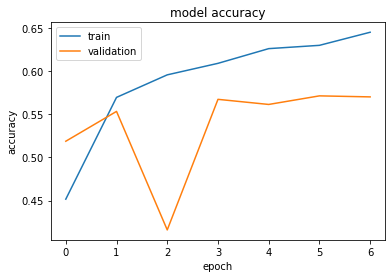

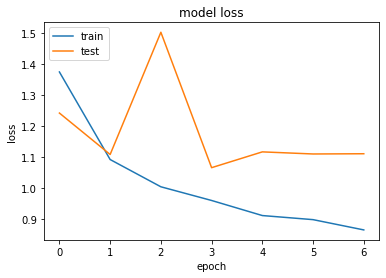

In [58]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model3.predict(data_test)
    labels_pred = np.round(labels_pred)
    accuracy = accuracy_score(y_test, labels_pred)
    f1 = f1_score(y_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(y_test, labels_pred))

Accuracy: 89.40%
F1 Score: 91.00
              precision    recall  f1-score   support

           0       0.95      0.87      0.90       275
           1       0.92      0.90      0.91       224
           2       0.91      0.95      0.93       695
           3       0.87      0.69      0.77       159
           4       0.97      0.93      0.95       581
           5       0.84      0.62      0.71        66

   micro avg       0.93      0.89      0.91      2000
   macro avg       0.91      0.82      0.86      2000
weighted avg       0.93      0.89      0.91      2000
 samples avg       0.89      0.89      0.89      2000



In [60]:
model3.save('model/word2vec_BiLSTM-Emotion.h5')